<a href="https://colab.research.google.com/github/natehorner/learn_pt_02/blob/main/pytorch_multiclassifciation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.9 MB/s eta 0:00:00


In [25]:
#common
import torch
from torch import nn
from torchmetrics import Accuracy
SEED_BASE = int("BADBEEF",16)
device = "cuda" if torch.cuda.is_available() else "cpu"

if(device == "cpu"):
  torch.manual_seed(SEED_BASE)
else:torch.cuda.manual_seed(SEED_BASE)


#Generate data
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#debug
import matplotlib.pyplot as plt

#meta statistics - 2 classes needed to plot...
NUM_CLASSES = 4
NUM_FEATURES = 6
EPOCHS = 2000


#create data - some of these are ugly with 4 classes, they can be on top of
#each other
X_blob,y_blob = make_blobs(n_samples = 1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std = 1.2, #changing this doesn't change the shape if seed is used
                           random_state=SEED_BASE+61) #I like the look of +6's data set

#make tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

#plt.figure(figsize=(10,7))
#plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,
    y_blob,test_size = 0.2,random_state=SEED_BASE)

#plt.figure(figsize=(10,7))
#plt.scatter(X_blob_train[:,0],X_blob_train[:,1],c=y_blob_train,cmap=plt.cm.RdYlBu)
#plt.scatter(X_blob_test[:,0],X_blob_test[:,1],c=y_blob_test,cmap=plt.cm.RdYlBu)

#X_blob_test.shape
#torch.Size([200, 2])
#X_blob_train.shape
#torch.Size([800, 2])

X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

acc_fn = Accuracy(task="MULTICLASS",num_classes=NUM_CLASSES).to(device)

#create the model
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

blob_model = BlobModel(input_features=NUM_FEATURES,output_features=NUM_CLASSES,hidden_units=16).to(device)

#loss/criterion/cost function and optimizer function
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=blob_model.parameters(),lr = 0.05)

#y_pred_raw = blob_model(X_blob_train[:10,:])
#y_pred_prb = torch.softmax(y_pred_raw,dim=1)
#y_pred_lbl = torch.argmax(y_pred_prb,dim=1)


for epoch in range(EPOCHS):
  blob_model.train()

  y_logits = blob_model(X_blob_train)
  y_pred_label = torch.argmax(torch.softmax(y_logits,dim=1),dim=1)

  loss_trn = loss_fn(y_logits,y_blob_train.long())
  train_acc = acc_fn(y_pred_label,y_blob_train)

  optim.zero_grad()
  loss_trn.backward()
  optim.step()
  blob_model.eval()

  #only test if we print... why would it test if it doesn't go anywhere?
  if epoch % 200 == 0 or epoch == EPOCHS-1:
    with torch.inference_mode():

      y_tst_lgt = blob_model(X_blob_test).squeeze()
      y_test_lbl = torch.argmax(torch.softmax(y_tst_lgt,dim=1),dim=1)
      loss_tst = loss_fn(y_tst_lgt,y_blob_test.long())

      test_acc = acc_fn(y_blob_test,y_test_lbl)

      print(f"Epoch: {epoch}, Train Loss: {loss_trn:.5f} Train Acc: {train_acc:.2f}%, Test Loss: {loss_tst:.5f} Test Acc: {test_acc:.2f}%")



Epoch: 0, Train Loss: 1.29531 Train Acc: 0.30%, Test Loss: 1.14015 Test Acc: 0.56%
Epoch: 200, Train Loss: 0.00292 Train Acc: 1.00%, Test Loss: 0.00291 Test Acc: 1.00%
Epoch: 400, Train Loss: 0.00113 Train Acc: 1.00%, Test Loss: 0.00107 Test Acc: 1.00%
Epoch: 600, Train Loss: 0.00067 Train Acc: 1.00%, Test Loss: 0.00061 Test Acc: 1.00%
Epoch: 800, Train Loss: 0.00047 Train Acc: 1.00%, Test Loss: 0.00042 Test Acc: 1.00%
Epoch: 1000, Train Loss: 0.00036 Train Acc: 1.00%, Test Loss: 0.00031 Test Acc: 1.00%
Epoch: 1200, Train Loss: 0.00029 Train Acc: 1.00%, Test Loss: 0.00025 Test Acc: 1.00%
Epoch: 1400, Train Loss: 0.00024 Train Acc: 1.00%, Test Loss: 0.00020 Test Acc: 1.00%
Epoch: 1600, Train Loss: 0.00020 Train Acc: 1.00%, Test Loss: 0.00017 Test Acc: 1.00%
Epoch: 1800, Train Loss: 0.00018 Train Acc: 1.00%, Test Loss: 0.00015 Test Acc: 1.00%
Epoch: 1999, Train Loss: 0.00016 Train Acc: 1.00%, Test Loss: 0.00013 Test Acc: 1.00%


In [ ]:
#debugging: plot how its making a decision since its not training/converging
#does it need an internal neuron set because 1 internal layer nhot enough?
import requests
from pathlib import Path

#download helper functions from pytorch repo if its not downloaded
if Path("helper_functions.py").is_file():
  print("helper_functions.pty is already downloaded")
else:
  print("download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)



RuntimeError: ignored

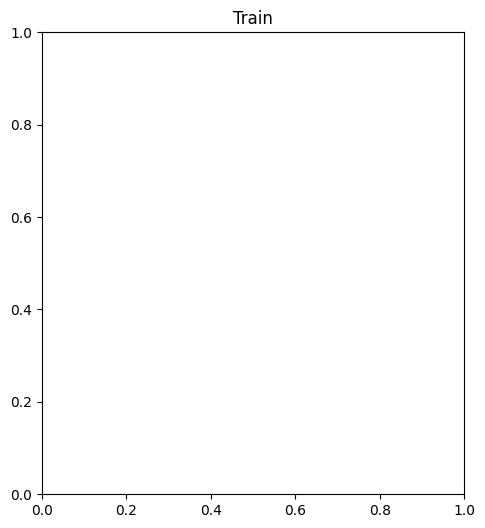

In [23]:
#plot decision boundary 10:56:05
from helper_functions import plot_predictions,plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(blob_model,X_blob_test,y_blob_test)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(blob_model,X_blob_test,y_blob_test)